In [1]:
# Imports
import sqlite3 as lite
import pandas as pd
import re
import numpy as np
import ast
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel 
from sklearn.svm import SVR, LinearSVC
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
conn = lite.connect('cycling_big.db')

riders_df = pd.read_sql_query('SELECT * FROM riders;', conn)
races_df = pd.read_sql_query('SELECT * FROM race_results', conn)

print("Amount of rows in races_df: ", races_df[races_df.columns[0]].count())
print("Amount of rows in riders_df: ", riders_df[riders_df.columns[0]].count())

conn.close()

"""
Convert the 'Date' column to DateTime format
Regarding races_df dataframe!
"""

races_df['Date'] = pd.to_datetime(races_df['Date'], errors='coerce', format='%d %B %Y')

# Remove rows where 'Date' is NaT
races_df = races_df.dropna(subset=['Date'])

# Normalize 'Date' to strip out time if it's present (this keeps just the date part)
races_df['Date'] = races_df['Date'].dt.normalize()

# Extract the month and year from the column and put them in their own columns
races_df['Month'] = races_df['Date'].dt.month
races_df['Year'] = races_df['Date'].dt.year

print("Unique values for 'months': ", races_df['Month'].unique(), "\n")
print("Unique values for 'years': ",races_df['Year'].unique())

"""
Converting the timetable to total seconds
"""

def time_to_seconds(time_str):
    # Remove commas and any spaces
    time_str = time_str.replace(',', '').strip()

    # Check the consistency of the time format using regular expressions
    match = re.match(r'(\d{1,2}):(\d{2}):(\d{2})', time_str)
    if match:
        hours, minutes, seconds = map(int, match.groups())
        total_seconds = hours * 3600 + minutes * 60 + seconds
        if total_seconds == 0:
            return np.nan
        return total_seconds

    # Do the same as the loop above, but now for MM:SS format.
    match = re.match(r'(\d{1,2}):(\d{2})', time_str)
    if match:
        minutes, seconds = map(int, match.groups())
        total_seconds = minutes * 60 + seconds
        if total_seconds == 0:
            return np.nan  
        return total_seconds

    # Do the same but for 0:00, 0:01, etc.
    match = re.match(r'(\d{1,2}):(\d{1,2})', time_str)
    if match:
        minutes, seconds = map(int, match.groups())
        total_seconds = minutes * 60 + seconds
        if total_seconds == 0:
            return np.nan 
        return total_seconds
    
    # If format doesn't match, return NaN
    return np.nan

# Apply the conversion function to the 'Time' column
races_df['Time_seconds'] = races_df['Time'].apply(time_to_seconds)

# print(races_df[['Time', 'Time_seconds']].head(10))
# races_df.info()

"""
Converting timelag to total seconds
"""

def timelag_to_seconds(timelag_str):
    # Check if the timelag_str contains missing values
    if pd.isna(timelag_str):
        return np.nan

    timelag_str = timelag_str.lstrip('+').strip()

    match = re.match(r'(\d{1,2}):(\d{2}):(\d{2})', timelag_str)
    if match:
        hours, minutes, seconds = map(int, match.groups())
        return hours * 3600 + minutes * 60 + seconds

    match = re.match(r'(\d{1,2}):(\d{2})', timelag_str)
    if match:
        minutes, seconds = map(int, match.groups())
        return minutes * 60 + seconds
    
    match = re.match(r'(\d+):(\d+)', timelag_str)
    if match:
        minutes, seconds = map(int, match.groups())
        return minutes * 60 + seconds

    return np.nan

races_df['Timelag_seconds'] = races_df['Timelag'].apply(timelag_to_seconds)

races_df['Timelag_seconds'] = races_df['Timelag_seconds'].replace(0.0, np.nan)

print(races_df[['Timelag', 'Timelag_seconds']].head(10))

"""
Converting distance into single numerical value
This means stripping 'km' from string and converting the remaining values into float64
"""

races_df['Length'] = races_df['Length'].str.replace(' km', '', regex=False)

# Convert to numeric and replace 0 with NaN
races_df['Length'] = pd.to_numeric(races_df['Length'], errors='coerce')  # Convert to numeric and handle errors

# Replace 0 values with NaN
races_df['Length'] = races_df['Length'].replace(0.0, np.nan)

# print(races_df['Length'])

"""
Splitting values from 'rdr' and putting the split values into separate columns
"""

# Function to convert the 'rdr' string to separate ranking columns
def extract_rankings(rdr_str):
    try:
        # Converting str to dict
        rankings = ast.literal_eval(rdr_str)
        
        # Extracting ranks, while also handling missing keys
        pcs_rnk = rankings.get('PCS Ranking', np.nan)
        uci_rnk = rankings.get('UCI World Ranking', np.nan)
        alltime_rnk = rankings.get('Specials | All Time Ranking', np.nan)
        
        return pd.Series([pcs_rnk, uci_rnk, alltime_rnk])
    except:
        return pd.Series([np.nan, np.nan, np.nan])

# Apply the function to the 'rdr' column
riders_df[['PCS_Rnk', 'UCI_Rnk', 'AllTime_Rnk']] = riders_df['rdr'].apply(extract_rankings)

# Entries should be turned into numeric values, where errors get turned into NaN
riders_df['PCS_Rnk'] = pd.to_numeric(riders_df['PCS_Rnk'], errors='coerce')
riders_df['UCI_Rnk'] = pd.to_numeric(riders_df['UCI_Rnk'], errors='coerce')
riders_df['AllTime_Rnk'] = pd.to_numeric(riders_df['AllTime_Rnk'], errors='coerce')

# print(riders_df[['fullname', 'PCS_Rnk', 'UCI_Rnk', 'AllTime_Rnk']])

"""
Convert stage types to binary with label encoding
"""

races_df['Stage_Type_bin'] = races_df['Stage_Type'].map({'RR': 0, 'ITT': 1})

"""
Splitting values from 'pps' and putting those values into separate columns.
"""

def extract_points(pps_str):
    try:
        points = ast.literal_eval(pps_str)
        
        day_pnt = np.nan if points.get('One day races', '0') == '0' else points.get('One day races', np.nan)
        gc_pnt = np.nan if points.get('GC', '0') == '0' else points.get('GC', np.nan)
        tt_pnt = np.nan if points.get('Time trial', '0') == '0' else points.get('Time trial', np.nan)
        sprint_pnt = np.nan if points.get('Sprint', '0') == '0' else points.get('Sprint', np.nan)
        climb_pnt = np.nan if points.get('Climber', '0') == '0' else points.get('Climber', np.nan)
        
        return pd.Series([day_pnt, gc_pnt, tt_pnt, sprint_pnt, climb_pnt])
    except:
        return pd.Series([np.nan, np.nan, np.nan, np.nan, np.nan])

riders_df[['Day_Pnt', 'GC_Pnt', 'TT_Pnt', 'Sprint_Pnt', 'Climb_Pnt']] = riders_df['pps'].apply(extract_points)

riders_df['Day_Pnt'] = pd.to_numeric(riders_df['Day_Pnt'], errors='coerce')
riders_df['GC_Pnt'] = pd.to_numeric(riders_df['GC_Pnt'], errors='coerce')
riders_df['TT_Pnt'] = pd.to_numeric(riders_df['TT_Pnt'], errors='coerce')
riders_df['Sprint_Pnt'] = pd.to_numeric(riders_df['Sprint_Pnt'], errors='coerce')
riders_df['Climb_Pnt'] = pd.to_numeric(riders_df['Climb_Pnt'], errors='coerce')


Amount of rows in races_df:  225918
Amount of rows in riders_df:  1042
Unique values for 'months':  [ 1  3  4  5  6  7  8  9 10] 

Unique values for 'years':  [2012 2014 2015 2017 2018 2020 2021]
  Timelag  Timelag_seconds
0   +0:00              NaN
1   +0:04              4.0
2   +0:06              6.0
3   +0:10             10.0
4   +0:10             10.0
5   +0:10             10.0
6   +0:10             10.0
7   +0:10             10.0
8   +0:10             10.0
9   +0:10             10.0


In [3]:
print(riders_df['fullname'])

0          BARDET Romain
1        DUMOULIN Samuel
2          GALLOPIN Tony
3          NAESEN Oliver
4          FRANK Mathias
              ...       
1037      TRONDSEN Trond
1038    VAN MELSEN Kévin
1039     BEULLENS Cédric
1040    DE WINTER Ludwig
1041      DELACROIX Théo
Name: fullname, Length: 1042, dtype: object


In [4]:
riders_df['fullname'] = riders_df['fullname'].str.replace(' ', '_') 
print(riders_df['fullname'])

0          BARDET_Romain
1        DUMOULIN_Samuel
2          GALLOPIN_Tony
3          NAESEN_Oliver
4          FRANK_Mathias
              ...       
1037      TRONDSEN_Trond
1038    VAN_MELSEN_Kévin
1039     BEULLENS_Cédric
1040    DE_WINTER_Ludwig
1041      DELACROIX_Théo
Name: fullname, Length: 1042, dtype: object


In [5]:
"""
Join the rider and race tables together, using the rider_id as an index
"""
print("Amount of rows in races_df post cleanup: ", races_df[races_df.columns[0]].count())
print("Amount of rows in riders_df post cleanup: ", riders_df[riders_df.columns[0]].count())

df = races_df.set_index('rider_id').join(riders_df.set_index('rider_id'), how = 'left')

print("Amount of rows in df: ", df[df.columns[0]].count())

"""
Dropping columns that are not needed for analysis
"""

# Note: fix the long list
df.drop(['Time', 'Timelag', 'rdr', 'pps', 'birthdate', 'rider_url', 'Race_url', 'Stage_url', 'Circuit', 'Race_Name', 'Stage_Name', 'Start', 'Finish', 'Category', 'Stage_Type'], axis=1, inplace=True)

# Additional drops:
df = df.drop(columns=['id', 'Team', 'Date', 'Race_ID', 'Stage_Number', 'Team'])
# Replace all remaining zero values with NaN
df = df.replace(0, np.nan)

print(df.isna().sum())
print("Amount of rows in df after cleanup: ", df[df.columns[0]].count())
print("\ndone")

Amount of rows in races_df post cleanup:  80174
Amount of rows in riders_df post cleanup:  1042
Amount of rows in df:  80174
Rnk                    0
GC                 10059
BiB                    0
Rider                  0
Age                    0
UCI                77527
Pnt                69767
Length              6495
Month                  0
Year                   0
Time_seconds       18435
Timelag_seconds    11212
Stage_Type_bin     72484
fullname           34208
team               34208
country            34208
height             34260
weight             34266
PCS_Rnk            45842
UCI_Rnk            46804
AllTime_Rnk        53300
Day_Pnt            34216
GC_Pnt             34208
TT_Pnt             34631
Sprint_Pnt         34342
Climb_Pnt          34365
dtype: int64
Amount of rows in df after cleanup:  80174

done


### PI 7: Part 3


#### 1.1 Appropriate Machine Learning Models
In this section, the selection of appropriate machine learning models in the context of the current dataset will be discussed.

#### 1.2.1 Categorical and Regression Trees
For the first model, the use of Categorical and Regression Trees will be discussed. As stated in *part 2* of the assignment, CART is a decision tree, that classifies records based on the conditions in the *decision nodes*, where the final classification, or regression, is determined in the *leaf nodes*. See the code from <code>pi7-2.ipynb</code> for a more in-depth explanation of decision trees.

#### 1.2.2 Argumentation
A regression tree will be implemented due to the following reasons:
- Handling possible non-linear relationships.
- It does not require any normalization/standardization, making outcomes more interpretable.
- It can handle outliers and missing values well.

Arguments against implementing regression trees:
- The more complex a tree becomes, the more prone it becomes to overfitting. There are methods for handling scenarios where overfitting can become an issue, like *pruning*.
- Sensitive to hyperparameters.
- Unsuitable for datasets with a large number of classes (see the arguments above).

#### 1.2.3 Implementation
Below is an implementation of a regression tree on the current dataset.

In [6]:
df.isnull().sum()

Rnk                    0
GC                 10059
BiB                    0
Rider                  0
Age                    0
UCI                77527
Pnt                69767
Length              6495
Month                  0
Year                   0
Time_seconds       18435
Timelag_seconds    11212
Stage_Type_bin     72484
fullname           34208
team               34208
country            34208
height             34260
weight             34266
PCS_Rnk            45842
UCI_Rnk            46804
AllTime_Rnk        53300
Day_Pnt            34216
GC_Pnt             34208
TT_Pnt             34631
Sprint_Pnt         34342
Climb_Pnt          34365
dtype: int64

'Rnk' or final rank will be used as our predictor variable. This column still contains alot of numerical values for 'DNF', meaning this will need to get cleaned up. Removing non-numericals, like DNF, DNS and OTL, does not impact the amount of available data by a large amount, so we will result in dropping these entries. Since these entries will most likely not contain any useful information (since the rider never finished or fouled), these entries will be dropped.

In [7]:
df['Rnk'].isna().sum()

np.int64(0)

In [8]:
df['Rnk'] = pd.to_numeric(df['Rnk'], errors='coerce')

In [9]:
df['Rnk'].isna().sum()

np.int64(5219)

In [10]:
df_ml = df.select_dtypes(include='number')

In [11]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80174 entries, 659ed585810c65fe22255a5e4a9b7838 to 0292146b9196ec7a98903cb50dae48cd
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Rnk              74955 non-null  float64
 1   GC               70115 non-null  float64
 2   Age              80174 non-null  int64  
 3   UCI              2647 non-null   float64
 4   Pnt              10407 non-null  float64
 5   Length           73679 non-null  float64
 6   Month            80174 non-null  int32  
 7   Year             80174 non-null  int32  
 8   Time_seconds     61739 non-null  float64
 9   Timelag_seconds  68962 non-null  float64
 10  Stage_Type_bin   7690 non-null   float64
 11  height           45914 non-null  float64
 12  weight           45908 non-null  float64
 13  PCS_Rnk          34332 non-null  float64
 14  UCI_Rnk          33370 non-null  float64
 15  AllTime_Rnk      26874 non-null  float64
 16  Day_P

To remove outliers and improve our error rating, outlier will be detected and subsequently removed using *isolation forest*.

For <code>contamination</code>, it will be assumed that 6% of our data contains outliers. 

In [12]:
q_low = df_ml.quantile(0.2)
q_hi = df_ml.quantile(0.8)

df_filtered = df_ml[(df_ml < q_hi) & (df_ml > q_low)]

In [13]:
imp = SimpleImputer(strategy='mean').set_output(transform='pandas')

imp.fit(df_filtered)
df_filtered = imp.transform(df_filtered)

/home/th0miz/Documents/School/DatSci_PI7-1/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['Stage_Type_bin']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


In [14]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80174 entries, 659ed585810c65fe22255a5e4a9b7838 to 0292146b9196ec7a98903cb50dae48cd
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Rnk              80174 non-null  float64
 1   GC               80174 non-null  float64
 2   Age              80174 non-null  float64
 3   UCI              80174 non-null  float64
 4   Pnt              80174 non-null  float64
 5   Length           80174 non-null  float64
 6   Month            80174 non-null  float64
 7   Year             80174 non-null  float64
 8   Time_seconds     80174 non-null  float64
 9   Timelag_seconds  80174 non-null  float64
 10  height           80174 non-null  float64
 11  weight           80174 non-null  float64
 12  PCS_Rnk          80174 non-null  float64
 13  UCI_Rnk          80174 non-null  float64
 14  AllTime_Rnk      80174 non-null  float64
 15  Day_Pnt          80174 non-null  float64
 16  GC_Pn

In [15]:
X = df_filtered.iloc[:, 1:]
y = df_filtered.iloc[:, 0]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.8)

#### 1.2.4 Random Forest Implementation

Below is an implementation of a random forest regressor. Notice how a pipeline is being set up to make feature selection more manageable.

In [17]:
forest = RandomForestRegressor(n_estimators=100)
forest.fit(X_test, y_test)

pipeline_forest = Pipeline([
    ('feature_selection', SelectFromModel(estimator=forest)),
    ('forest_regression', RandomForestRegressor(n_estimators=100, random_state=42))
])

pipeline_forest.fit(X_train, y_train)

score = pipeline_forest.score(X_test, y_test)
print(f"Pipeline test score: {score}")

y_pred_dtr = pipeline_forest.predict(X_test)

Pipeline test score: 0.28729673106258613


#### 1.3.1 Histogram-based Gradient Boosting Regression


In the following section, *Histogram-based Gradient Boosting Regression* will be discussed. 

This machine learning model makes use of *gradient boosting* and the construction of histogram-based features.

*Gradient boosting* is an ensemble method which makes use of regression trees. 

**What is ensemble learning?**
- Ensemble learning is a model that will construct a number of models, with the aim to improve its prediction rate.
Two popular ensemble methods include *bagging* (Bootstrap Aggregation) and *boosting*. With bagging, weak models are trained in parallel, where each model learns from a given partition of the dataset. The results from each of these models are then combined by either averaging (regression) or voting (classification). With boosting, a sequential method, each model is trained on a weighted training set, where each model corrects the weights based on the error from its predecessors.


Gradient boosting is a boosting method, which works by building multiple, weaker, prediction models in sequence. Each time a model is constructed, it will (try to) predict the error that is left over by its model, and uses this information to build the next model. Gradient boosting makes use of combining predictions of multiple weak learners, usually decision trees.


**How does Hist Gradient Boosting work?**
This model is similar to gradient boosting, as it is an ensemble technique which uses boosting, but instead of using decision trees as weak learners, it makes use of histograms. Using histograms is computationally more efficient, making it faster compared to traditional gradient boosting, especially on larger datasets. Building a histogram has a notation of $O(nfeatures​×n)$, whereas gradient boosting is of $O(nfeatures​×nlog(n))$.

#### 1.3.2 Argumentation
- Faster training times.
- It can handle larger datasets.
- Data does not need to be normalized.
- Histogram-based can handle non-linear interaction.

#### 1.3.3 Implementation
See below for the implementation of histogram-based gradient boosting.

In [18]:
X_test.shape, y_test.shape

((16035, 19), (16035,))

In [19]:
pipeline_hgb = Pipeline([
    ('hgb', HistGradientBoostingRegressor(loss='poisson', max_bins=255))
])

pipeline_hgb.fit(X_train, y_train)

y_pred_hgb = pipeline_hgb.predict(X_test)

In [20]:
hgb = HistGradientBoostingRegressor(loss='poisson', max_bins=255).fit(X_train, y_train)
y_pred_hgb = hgb.predict(X_test)

For testing purposes, the $R^2$ score, which returns the coefficient of determination of the prediction, was included in the codeblock above. More on metrics will follow in **2.1 Metrics for Models**.

#### 1.4 Support Vector Regression (SVR)
In the following section, SVR will be discussed and showcased.

SVR is a type of learning model, found in the set of models from Support Vector Machines (SVM). SVM is a supervised model that can handle noth unstructured data as well as nonlinear relationships in high dimensional spaces. This is made possible due to a nifty feature of this type of model: the *kernel trick* or also called *kernel method*.

#### The Kernel Method
The kernel method aims to solve two problems with on solution.
**Problem 1**: 
relies on a nonlinear transformation of the points in a dataset. Say X and Y are plotted against on another. By 

In [21]:
pipeline_svr = Pipeline([
    ('scaler', StandardScaler()),  # Normalize the data
    ('svr', SVR(kernel='rbf', C=1.0, epsilon=0.2))  # SVR model
])

# Fit the pipeline on the training data
pipeline_svr.fit(X_train, y_train)

# Make predictions
y_pred_svr = pipeline_svr.predict(X_test)

#### 2.1 Metrics for Models

In the following section, metrics for analyzing the performance of the used models will be explained and demonstrated.

Since regression models are being used, the following general metrics will be used:
- Mean absolute error (MAE) and mean absolute percentage error (MAPE).
- Coefficient of determination ($R^2$).

For random forest, feature importance will be used as a metric for evaluating the amount times a feature is used in each tree of the model.

#### 2.2 Mean Absolute (Percentage) Error


With MAE, the magnitude of the average absolute error, or also called deviation, is determined.
For MAPE, the same is achieved as with MAE, except it will return this as a precentage. Thus, this measure gives a percentage score of how predictions deviate from the actual values. 

Below, the MAE and MAPE for each of the models will be given, and will be interpreted.

In [22]:
mae_dtr = mean_absolute_error(y_test, y_pred_dtr)
mape_dtr = mean_absolute_percentage_error(y_test, y_pred_dtr)

mae_hgb = mean_absolute_error(y_test, y_pred_hgb)
mape_hgb = mean_absolute_percentage_error(y_test, y_pred_hgb)

mae_svr = mean_absolute_error(y_test, y_pred_svr)
mape_svr = mean_absolute_percentage_error(y_test, y_pred_svr)

print("Decision Tree regression:\n\nMean absolute error: ", mae_dtr, "\nMean absolute percentage error: ", mape_dtr,
      "\n\nHistogram-based gradient boosting:\nMean absolute error: ", mae_hgb, "\nMean absolute percentage error: ", mape_hgb,
      "\n\nSupport vector regression:\nMean absolute error: ", mae_svr, "\nMean absolute percentage error: ", mape_svr)

Decision Tree regression:

Mean absolute error:  11.72926269614719 
Mean absolute percentage error:  0.17332448603353287 

Histogram-based gradient boosting:
Mean absolute error:  12.679903035281708 
Mean absolute percentage error:  0.18913736521226673 

Support vector regression:
Mean absolute error:  12.60602342048053 
Mean absolute percentage error:  0.19033841213374497


Looking at our metrics

#### 2.3 Coefficient Determination

In [ ]:
r2_dtr = r2_score(y_test, y_pred_dtr)
r2_hgb = r2_score(y_test, y_pred_hgb)
r2_svr = r2_score(y_test, y_pred_svr)

print(" . . R2 scores . . \n\nR^2 for random forest: ", r2_dtr,
      "\nR^2 for histogram-based gradient boost: ", r2_hgb,
      "\nR^2 for support vector regression: ", r2_svr)

 . . R2 scores . . 

R^2 for decision tree:  0.28729673106258613 
R^2 for histogram-based gradient boost:  0.22531128453612748 
R^2 for support vector regression:  0.11078191543273053


#### 2.4 Feature Importance



In [24]:
importances = forest.feature_importances_

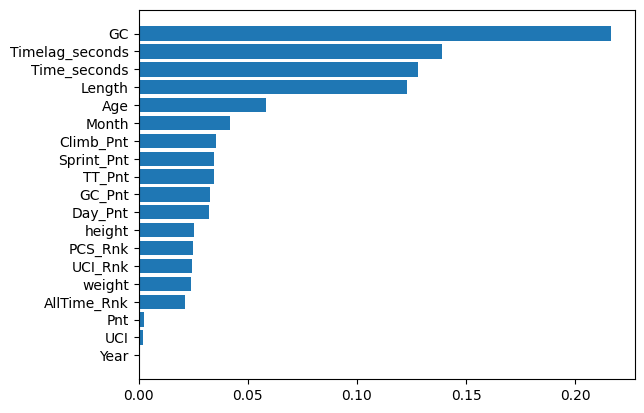

In [25]:
indices = np.argsort(importances)

fig, ax = plt.subplots()
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(X_train.columns)[indices])

#### 3.1.1 Cross-validation

Cross validation (cv) is the act of splitting the dataset, that will be used for the training of a machine learning model.
In this section, the results of research about the preparation of data for cross-validation will be discussed.

Lets start off by evaluating the meaning of cross validation.

When an entire dataset is both used for training and testing the model, it will be very accurate, since the model will use the memorized labels during training for testing its own performance. This is also called *overfitting*, where the model memorized the data instead of learning from it. Thus, it is good practice to hold out a part of the dataset for testing, since the model has never used this partition of the dataset for training purposes. Cv takes this a step further, by splitting the dataset into a training and a testing partition. With this, multiple instances of a model will be trained, where each model will have the test partition shifted around. By iterating over different splits during each sequentially trained model, a more accurate claim can be made for the performance of the trained model. See below for a visual representation.


![alt text](image.png)


[Scikit-learn](http://example.com)


With this, the basics of *k-fold cross-validation* (k-cv), and thus cv itself, has been outlined, where the training set is split into *k* smaller sets, called "k folds".


##### 3.1.2 Cross Validation for Hyperparameters

However, the data used for training is not the only reason the prediction power of a model can be influenced. ML models are tuned based on *hyperparameters* to control their behaviour. For instance, the prediction power for a random forest model can rely on the maximum depth of the tree, the minimum number of samples require to allow a split and more. To dive deeper into researching what hyperparameters work best for a given model, cross validation can be used to have a certain model train over the dataset, while iterating through the definitions for hyperparameters. The results from cross validation can be interpreted to make a claim over which hyperparameters work best for a given model.

So in short, it can be stated that the hyperparameter space can be iteratively searched for the best cross validation score. But how are hyperparameters evaluated? Two methods will be discussed below.

1. **Exhaustive grid search**

With a grid search, the hyperparameters are specified from a grid of parameter values. The values that will be evaluated are predefined in a grid, where in each following evaluation, the next hyperparameter value is evaluated. By doing this, all the possible combinations of predefined hyperparameters are evaluated, which will result in the best combination of parameters that are defined in the grid. This method is one of the more widely used methods for validating the most optimal hyperparameters for a machine learning model.

2. **Randomized parameter optimization**

Randomized parameter optimization takes a different approach to finding the ideal hyperparameters. This method implements a randomized search over the available hyperparameters, where each setting

#### 3.1.3 Evaluating Hyperparameters
For this section, the hyperparameters per model will be evaluated.

##### Random Forest

#### 3.2 Implementation of Cross-validation



#### 4.1 Ideal Hyperparameters

#### 5.1 Conclusions

#### Bibliography:
Chicco, D., Warrens, M. J., & Jurman, G. (2021). The Coefficient of Determination R-squared Is More Informative than SMAPE, MAE, MAPE, MSE and RMSE in Regression Analysis Evaluation. *PeerJ Computer Science, 7(5)*, e623. ncbi. https://doi.org/10.7717/peerj-cs.623


*Cross-validation: Evaluating Estimator Performance*. (2009). Scikit-Learn.org. https://scikit-learn.org/stable/modules/cross_validation.html


‌*Ensembles: Gradient boosting, random forests, bagging, voting, stacking*. (2022). Scikit-Learn. 
    https://scikit-learn.org/stable/modules/ensemble.html#gradientboostingclassifier-and-gradientboostingregressor


*HistGradientBoostingRegressor*. (n.d.). Scikit-Learn. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html


*Support Vector Regression - Coastal Wiki.* (2024). Coastalwiki.org. https://www.coastalwiki.org/wiki/Support_Vector_Regression


*The Kernel Trick in Support Vector Machine (SVM).* (2022, May 9).  YouTube. https://youtu.be/Q7vT0--5VII?si=UPm5UYwL1Dtsgkhw

‌